In [1]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data as pdr
import datetime as dt
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [15]:
ticker = input("Insert a ticker: ")
start = "2016-01-01"
end = "2022-12-31"

yf.pdr_override()
data = pdr.get_data_yahoo(ticker, start=start, end=end)
data.head()

Insert a ticker: GOOG
GOOG
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,37.150002,37.202999,36.562901,37.091999,37.091999,65456000
2016-01-05,37.322498,37.599998,36.931999,37.129002,37.129002,39014000
2016-01-06,36.500000,37.359001,36.445999,37.181000,37.181000,38940000
2016-01-07,36.515499,36.924999,35.952999,36.319500,36.319500,59274000
2016-01-08,36.572498,36.661499,35.650002,35.723499,35.723499,49018000


In [16]:
data['Daily Return'] = data['Adj Close'].pct_change()
ticker_close = data.filter(['Adj Close'])
dataset = ticker_close.values
# training_data_len = int(np.ceil(len(dataset)*0.8))
training_data_len = int(len(dataset)*0.8)

In [22]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [18]:
#Training Data Set
train_data = scaled_data[0:int(training_data_len),:]
# print(train_data)
x_train = []
y_train = []

for i in range(80,len(train_data)):
    x_train.append(train_data[i-80:i,0])
    y_train.append(train_data[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)
# print(x_train.shape)

#Reshaping the data
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
# print(x_train.shape)

In [19]:
from scipy.optimize import optimize
model = Sequential()
model.add(LSTM(80, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(80, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(80))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(x_train, y_train, epochs = 25, batch_size = 32)

Epoch 1/25
42/42 [==============================] - 16s 187ms/step - loss: 0.0120
Epoch 2/25
42/42 [==============================] - 9s 207ms/step - loss: 0.0013
Epoch 3/25
42/42 [==============================] - 9s 217ms/step - loss: 0.0013
Epoch 4/25
42/42 [==============================] - 8s 185ms/step - loss: 0.0013
Epoch 5/25
42/42 [==============================] - 10s 241ms/step - loss: 0.0016
Epoch 6/25
42/42 [==============================] - 9s 216ms/step - loss: 0.0011
Epoch 7/25
42/42 [==============================] - 8s 190ms/step - loss: 0.0011
Epoch 8/25
42/42 [==============================] - 10s 242ms/step - loss: 0.0011
Epoch 9/25
42/42 [==============================] - 10s 242ms/step - loss: 0.0011
Epoch 10/25
42/42 [==============================] - 9s 218ms/step - loss: 9.3070e-04
Epoch 11/25
42/42 [==============================] - 8s 185ms/step - loss: 9.9147e-04
Epoch 12/25
42/42 [==============================] - 9s 218ms/step - loss: 0.0011
Epoch 13/25
4

In [20]:
test_data_end = int(np.ceil(len(dataset)*0.2)) + training_data_len
test_data = scaled_data[training_data_len - 80:test_data_end, :]
x_test = []
y_test = dataset[training_data_len:test_data_end, :]
for i in range(80,len(test_data)):
    x_test.append(test_data[i-80:i, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

test_prediction = model.predict(x_test)
test_prediction = scaler.inverse_transform(test_prediction)
test_error = np.sqrt(np.mean((test_prediction - y_test)**2))
scores = model.evaluate(x_test,y_test, verbose = 0)

train = ticker_close[:training_data_len]
test = ticker_close[training_data_len:test_data_end]
test['Test Predictions'] = test_prediction

12/12 [==============================] - 2s 58ms/step


<ipython-input-20-5002e970422c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Test Predictions'] = test_prediction


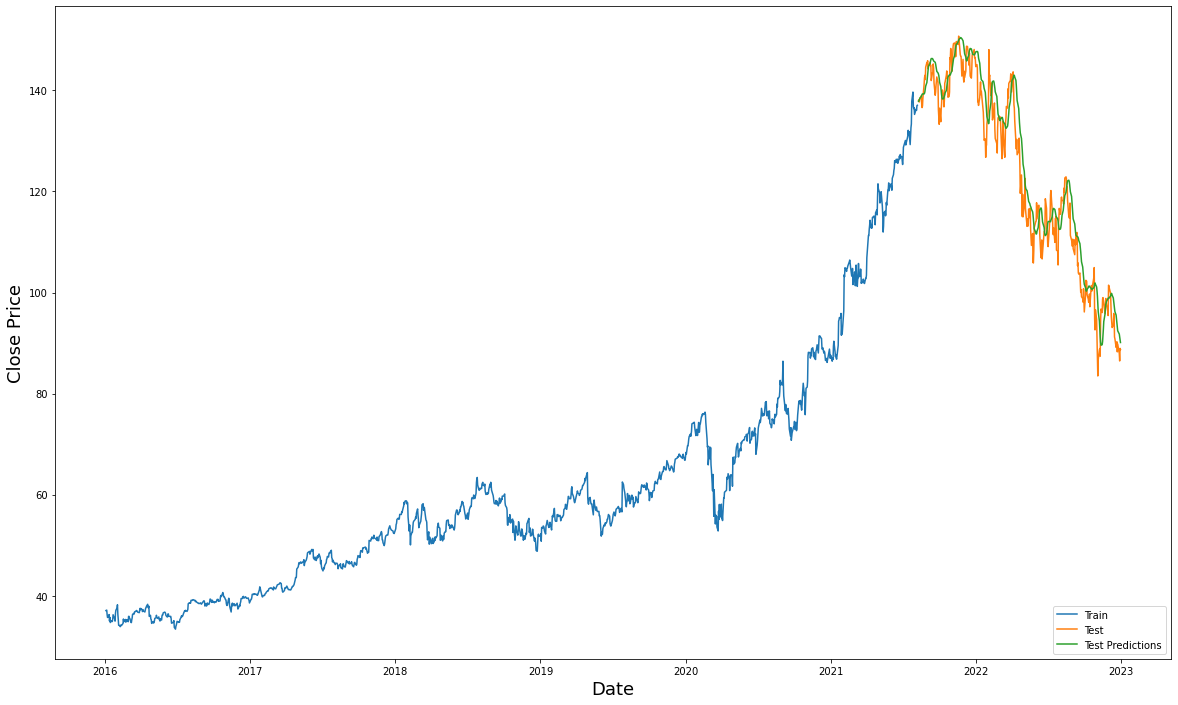

In [21]:
plt.figure(figsize=(20,12))
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['Adj Close'])
plt.plot(test[['Adj Close', 'Test Predictions']])
plt.legend(['Train', 'Test', 'Test Predictions'], loc='lower right')
plt.show()